In [1]:
import os
import shutil 
import xml.etree.ElementTree as ET
import pandas as pd
import glob

import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

label_dic = {0: 'LockerCover_40273904', 1: 'Turbocharger_40376582', 2: 'Spacer_40309382', 3: 'SensorWaterTemp_40273637',
             4: 'ExhaustManifold_40268003', 5: 'ACVHoseB_40265762', 6: 'Spacer_40322591', 7: 'Flywheel_40370807',
             8: 'EGRCooler_40380976', 9: 'RearCase_40324088', 10: 'OilFiller_40265587', 11: 'CrankPulley_40265565',
             12: 'TimingCase_40273907', 13: 'WaterPump_40344260', 14: 'Heatsink_40288672', 15: 'OilFilter_40409065',
             16: 'OilCooler_40336395', 17: 'OilPan_40414815', 18: 'InjectionPump_40265601', 19: 'LockerCover_40306424',
             20: 'OilFilter_40318590', 21: 'InjectionPipe_40248301~3', 22: 'IntakeManifold_40306419',
             23: 'WaterPump_40376775', 24: 'OilFillerCover_40007385', 25: 'Flywheel_40389980', 26: 'Heatplug_40007624',
             27: 'RearCase_40277239', 28: 'CrankPulley_40233127', 29: 'TimingCase_40277238', 30: 'OilFiller_40395153',
             31: 'BearingCase_40009045', 32: 'OilPan_20021510', 33: 'ReliefValve_40006985', 34: 'Spacer_40309381',
             35: 'EGRValve_40446187', 36: 'ACVPipe_40446923', 37: 'ACV_40265758', 38: 'ACVHoseA_40322597',
             39: 'FuelFilter_40354756', 40: 'Flywheel_40446749', 41: 'EGRPassage_40446684', 42: 'RearCase_40446748',
             43: 'OilFiller_40332649', 44: 'OilPan_20165463', 45: 'SensorP2_40273639', 46: 'ExhaustManifold_40354759',
             47: 'Flywheel_40272348', 48: 'RearCase_40268001', 49: 'FuelFilter_40407354', 50: 'OilPan_40414814',
             51: 'Flywheel_40272344', 52: 'EGRCooler_40266106', 53: 'ExhaustManifold_40268002',
             54: 'LockerCover_40273903', 55: 'RearCase_40267499', 56: 'OilFiller_40414522', 57: 'CrankPulley_40009209',
             58: 'OilPan_40272349', 59: 'PreFilter_40266160', 60: 'Spacer_40439261', 61: 'RearCase_40312247',
             62: 'OilPan_40415242', 63: 'ACVPipe_40322598', 64: 'Flywheel_40322582', 65: 'RearCase_40322595',
             66: 'OilPan_20153073', 67: 'MainFilter_40407355', 68: 'Spacer_40294842', 69: 'InjectionPump_11111111',
             70: 'Flywheel_40272347', 71: 'RearCase_40267500', 72: 'WaterPump_40376807', 73: 'Spacer_40009955',
             74: 'IntakeManifold_40306416', 75: 'LockerCover_40306422', 76: 'InjectionPipe_40011025~8',
             77: 'Flywheel_40389977', 78: 'RearCase_20020362', 79: 'OilFiller_40326392', 80: 'TimingCase_40325870',
             81: 'OilPan_40315597', 82: 'Turbocharger_40436004', 83: 'ExhaustManifold_40008974',
             84: 'OilCooler_40007587', 85: 'RearCase_40279774', 86: 'IntakeManifold_40237804',
             87: 'LockerCover_40295008', 88: 'InjectionPipe_40215204~7', 89: 'ExhaustManifold_40220568',
             90: 'AirHeater_40217404', 91: 'Flywheel_40355151', 92: 'AirHeater_40376259', 93: 'OilFiller_40415846',
             94: 'RearCase_40298672', 95: 'OilPan_20022496', 96: 'Flywheel_40389981', 97: 'Flywheel_40353462',
             98: 'RearCase_40352881', 99: 'OilPan_20153074', 100: 'FuelFilter_40271220', 101: 'bg'}

In [37]:
import params
import json

import os
import pandas as pd

label_dic = params.label_dic
standard_label_path = r'D:/hm/Projoects/anno2anno/anno_sample_0710.csv'

# 라벨 딕셔너리 역방향 생성
reversed_label_dic = {value: key for key, value in label_dic.items()}
yolo_result_dir = r'yolov5/runs/detect/exp6/labels'

# 표준 레이블 데이터 로드 및 라벨 변환
standard_label_data = pd.read_csv(standard_label_path)

standard_label_data['classes'] = standard_label_data['classes'].replace(reversed_label_dic)

# 이미지 프리픽스 생성
standard_label_data['image_prefix'] = standard_label_data['image_id'].str[:2]

# YOLO 결과 파일 목록 가져오기
yolo_result_files = os.listdir(yolo_result_dir)

# 그룹화된 클래스 데이터 생성
grouped_classes = standard_label_data.groupby('image_id')['classes'].apply(list).reset_index()

# 이미지 프리픽스별 클래스 집합 생성
sample_grouped = standard_label_data.groupby('image_prefix')['classes'].apply(set).apply(sorted).reset_index()

# JSON 형식으로 저장할 데이터를 담을 리스트 생성
unchecked_data = []

for i in range(len(grouped)):
    try:
        tmp = sample_grouped.loc[sample_grouped['image_prefix'] == grouped['image_id'][i][:2], 'classes'].values
        image_id = grouped['image_id'][i].replace("_", "").replace(".bmp", "")

        if len(set(tmp[0]) - set(grouped['parts'][i])) == 0:
            print(image_id, 'is OK')
        else:
            # 미검 데이터 정보를 딕셔너리로 생성
            unchecked_item = {
                "root_number": image_id,
                "reasons": []
            }
            for j in set(tmp[0]) - set(grouped['parts'][i]):
                unchecked_item["reasons"].append({
                    "part": label_dic[j],
                    "status": "미검"
                })
            # JSON 데이터에 추가
            unchecked_data.append(unchecked_item)
    except IndexError as e:
        print("그룹화된 데이터에 대한 샘플 데이터 없음:", grouped['image_id'][i][:2])
        pass

# JSON 파일로 저장 (한국어 인코딩 적용)
with open('unchecked_data_val.json', 'w', encoding='utf-8') as json_file:
    json.dump(unchecked_data, json_file, ensure_ascii=False, indent=4)

print("미검 데이터를 JSON 파일로 저장했습니다.")

미검 데이터를 JSON 파일로 저장했습니다.


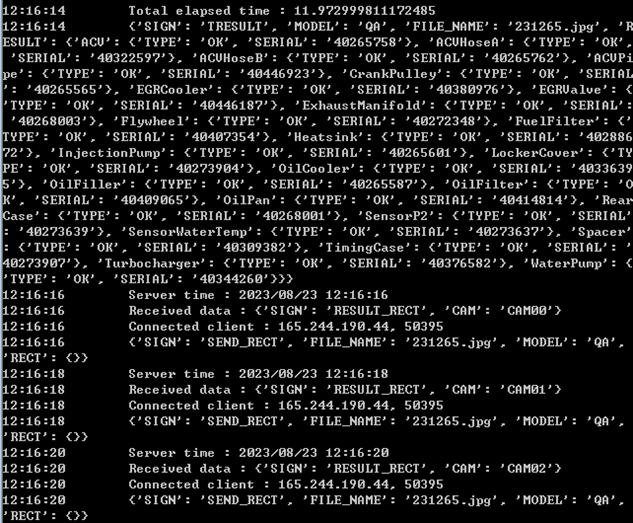
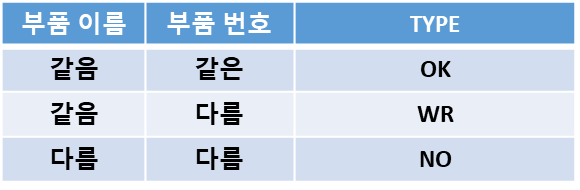